More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [ ]:
!pip install ftfy
!pip install contractions

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=5c1bac2332ec0f34bdd48d64e440d0e7dd30a2a76dcbea29ccfa407cf8c3d7b1
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c21c0887af1bfe31908fbf
Successfully built ftfy
     |████████████████████████████████| 317kB 4.3MB/s 
     |████████████████████████████████| 245kB 18.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81696 sha256=0f85c3ea48a9e6f6411abf85f727fe70649f363873201a7d9d9a188f5ffccd98
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
  
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy import stats
import nltk
import string, contractions
import ftfy


from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
data = pd.read_excel("/content/drive/My Drive/Colab Notebooks/NLP/ISB-Clustering/Company Descriptions.xlsx")

In [ ]:
data.fillna(value = "", inplace=True)

In [ ]:
data.isna().sum()  # No NaNs now

company_name                 0
company_short_description    0
company_description          0
dtype: int64

#### merge the two description column for each company, to make the best possible informative clusters

In [1]:
#data.head(-5)

In [ ]:
for i in range(len(data)):
  if data.loc[i, "company_description"] == "" or len(data.loc[i, "company_description"]) < 10:
    data.at[i, "merged_desc"] = data.loc[i, "company_short_description"]
  else:
    data.at[i, "merged_desc"] = data.loc[i, "company_description"]

In [ ]:
#data["merged_desc"] = data["company_short_description"] + " " + data["company_description"]

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Create our list of punctuation marks
punctuations = string.punctuation
                      
# Creating our tokenizer function
def text_tokenizer(text):
    
    #Trim upto the last word within 500 character length
    maxLength = 500

    if len(text) > maxLength:
        #trim the string to the maximum length
        trimmedString = text[0:maxLength]

        #re-trim if we are in the middle of a word
        #print(min(len(trimmedString), trimmedString.rindex(" ")))
        text = trimmedString[0 : min(len(trimmedString), trimmedString.rindex(" "))]

    # encoding the text back to ascii as it contains some invalid characters like â€™, â€“, Â®
    text = ftfy.fix_text(text)

    # Replace contractions in string of text
    text = contractions.fix(text)

    # Removing URLs, "\n" and unwanted spaces
    text = re.sub(r'https?:\/\/\S*|www.?\S*|[a-z]*[0-9]*[.]com', ' ', text, flags=re.MULTILINE).strip()
    text = re.sub('\n',' ', text)
    text = re.sub('\s+',' ', text)

    # Removing punctuations
    table = str.maketrans(' ', ' ', string.punctuation)
    mytokens = ' '.join([w.translate(table) for w in text.split()])

    # Converting each token into lowercase and extracting only strings 
    mytokens= ' '.join([word.lower() for word in mytokens.split() if word.isalpha()])
    
    # Removing stop words
    mytokens = ' '.join([ word for word in mytokens.split() if not word in stop_words])
    
    # # Lemmatize words
    lemmatized = lemmatize_sentence(mytokens)

    # return preprocessed list of tokens
    return lemmatized

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
final_text = []  # transformed list of company descriptions
for text in data["merged_desc"]:
    final_text.append(text_tokenizer(text))

In [2]:
#final_text

In [3]:
message_embeddings = embed(final_text)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(final_text[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))
  break

In [ ]:
message_embeddings

<tf.Tensor: shape=(19965, 512), dtype=float32, numpy=
array([[-0.01509814, -0.04989455,  0.01001029, ...,  0.01598569,
        -0.02476936, -0.04051499],
       [ 0.04958095, -0.06278804, -0.03077463, ...,  0.01054108,
        -0.06399643, -0.06058563],
       [-0.06754484, -0.02936127, -0.01983172, ...,  0.00691496,
        -0.03042461, -0.03124638],
       ...,
       [ 0.01501418, -0.06435572,  0.00760609, ...,  0.03242135,
        -0.05006365, -0.06279271],
       [-0.00789589, -0.06296685, -0.02997911, ...,  0.02949246,
        -0.00134951, -0.08760481],
       [-0.03284988, -0.04264485,  0.03746532, ...,  0.06243652,
        -0.06090641, -0.0210698 ]], dtype=float32)>

In [ ]:
use_embeddings = message_embeddings.numpy()

### HDBSCAN and UMAP Clustering

In [ ]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 3.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2307208 sha256=3d1283ac6cacb5031cd62c5a8dda6ff9b7f006a6f86e6f4cd970580ff5f1974b
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [ ]:
import umap
import hdbscan

In [ ]:
%%time
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(use_embeddings)

CPU times: user 1min 3s, sys: 1.61 s, total: 1min 5s
Wall time: 1min 4s


In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=30,
    min_cluster_size=200,
).fit_predict(clusterable_embedding)

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4])

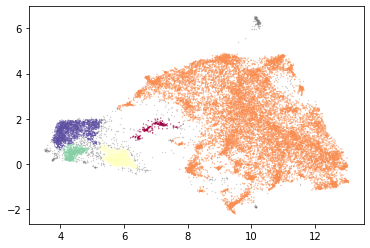

In [ ]:
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
np.sum(clustered) / len(use_embeddings)

0.9549711995992988

In [ ]:
len(use_embeddings), np.sum(clustered)

(19965, 19556)

In [4]:
final_df = pd.DataFrame({'company_name':data.company_name, 'description': data.merged_desc, 'cluster': labels})
# final_df.head()

In [ ]:
final_df.to_csv('Output.csv', index=False)

### Common functions

In [ ]:
def find_k(normalized_doc_embeddings):
  wcss = []
  start_elbow = 2
  end_elbow = 20
  for i in range(start_elbow,end_elbow):
      kmeans = KMeans(n_clusters=i,init='k-means++', random_state = 42)
      kmeans.fit(normalized_doc_embeddings)
      wcss.append(kmeans.inertia_)
      print(silhouette_score(normalized_doc_embeddings, labels=kmeans.predict(normalized_doc_embeddings)))

  plt.plot(range(start_elbow,end_elbow), wcss)
  plt.title('The Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.show()

In [ ]:
def export_prediction(input, no_clusters=5):
  sentence_clf = KMeans(n_clusters=no_clusters,
                      max_iter=100,init='k-means++',
                      n_init=1, random_state = 42)
  labels = sentence_clf.fit_predict(input)
  final_df = pd.DataFrame({'company_name':data.company_name, 'cluster': labels})
  final_df.head()
  final_df.to_csv("output_task_3b.csv", index=False)

### PCA on normalized data 

#### Normalize and transform data using PCA

In [ ]:
X_norm  = stats.zscore(use_embeddings, axis=0)  # normalize using zscore

In [ ]:
pca = PCA()
pca.fit(X_norm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

#### Finding best value of PCA components

Text(0, 0.5, 'Cumulative Explained Variance')

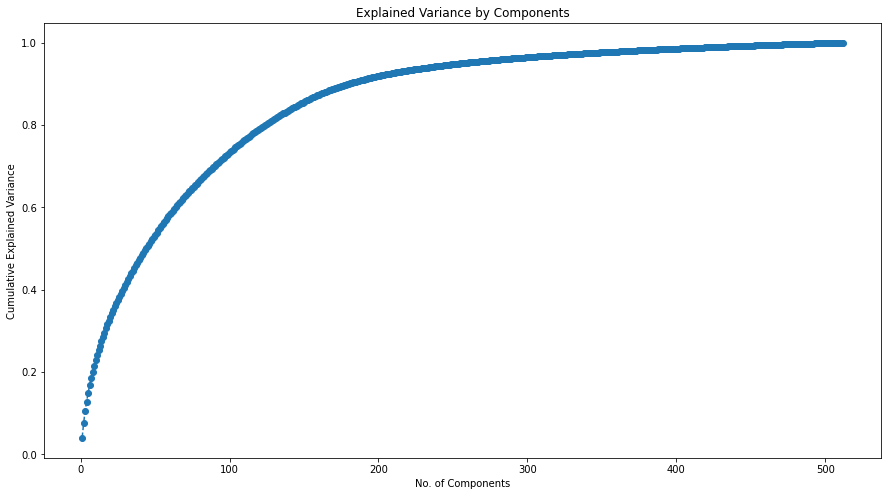

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(1,513), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle = "--", )
plt.title("Explained Variance by Components")
plt.xlabel("No. of Components")
plt.ylabel("Cumulative Explained Variance")

In [ ]:
#reducing to 20 components as depicted from above figure while keeping 90% of info

In [ ]:
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_norm)

### t-SNE and Clustering

#### Creating t-SNE object 

In [ ]:
!pip install MulticoreTSNE

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0)

In [ ]:
tsne_obj = tsne.fit_transform(X_pca)

#### t-SNE with KMeans

0.41244593591434275
0.40894235919310007
0.39146367642752794
0.3637497632893426
0.3695845034240872
0.3654119801750848
0.3612609896311166
0.3647165100775767
0.36295532186604174
0.35965502406778715
0.34929564730788587
0.35237745160627987
0.3481584892602221
0.3451068669834822
0.3478270463539925
0.3503574480921724
0.3485325872504799
0.3475652026124374


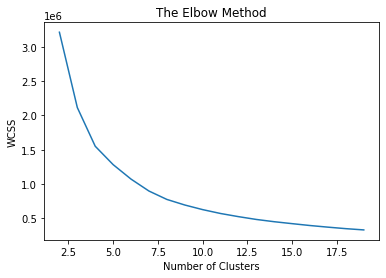

In [ ]:
find_k(tsne_obj)

### UMAP and K-Means clustering post PCA

In [ ]:
import umap.umap_ as umap

In [ ]:
#!pip install umap

In [ ]:
%%time
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_pca)

CPU times: user 48 s, sys: 1.25 s, total: 49.3 s
Wall time: 48.5 s


0.4788369
0.43610492
0.44127893
0.4156877
0.42072254
0.42553678
0.4148531
0.40115848
0.40212977
0.41086707
0.43320888
0.42508668
0.4209003
0.42783177
0.42515436
0.41502678
0.4179271
0.42100513


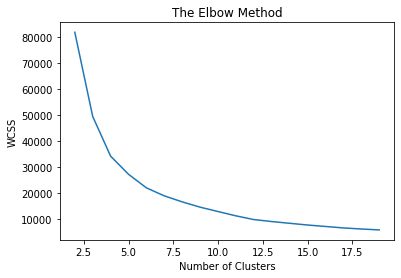

CPU times: user 2min 19s, sys: 47.6 s, total: 3min 7s
Wall time: 2min


In [ ]:
%%time
find_k(clusterable_embedding)